# Импорт библиотек

In [1]:
from turbine.average_streamline.turbine import Turbine
from turbine.profiling.turbine import TurbineProfiler
from turbine.profiling.stage import ProfilingType, StageProfiler, ProfilingResultsForCooling
from turbine.profiling.section import BladeSection
import numpy as np
import pickle
from gas_turbine_cycle.gases import Air
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd
import config
import os
from turbine.cooling.film_defl import get_sa_cooler, FilmBladeCooler, FilmSectorCooler
from turbine.cooling.tools import get_theta, get_T_gas, get_g_cool, LocalParamCalculator, FilmCalculator

## Загрузка результатов расчета цикла

In [2]:
with open(os.path.join(config.output_dirname, 'cycle.cyc'), 'rb') as file:
    units = pickle.load(file)[0]
comp = units['compressor']
turb_load = units['turb_load']

N_e_specific = turb_load.consumable_labour
G_air = turb_load.power / N_e_specific

T_c_stag = comp.T_stag_out
p_c_stag = comp.p_stag_out


## Загрузка результатов расчета по средней линии

In [3]:
def get_turbine_res(fname):
    file = open(fname, 'rb')
    res = pickle.load(file)
    file.close()
    return res
turbine: Turbine = get_turbine_res(os.path.join(config.output_dirname, 'comp_turbine_ave_line.avl'))['turbine']

## Загрузка результатов профилирования

In [4]:
with open(os.path.join(config.output_dirname, 'comp_turb_st1_prof_for_cool.prof'), 'rb') as file:
    profiling = pickle.load(file)

blade_num = profiling.blade_num

# Расчет конвективно-пленочного охлаждения СА первой ступени с поперечно-петлевой схемой течения охлаждающего воздуха

### Теплопроводность материала лопатки (ЭИ-929)

Рекомендумая максимальная температура при длительной эксплутации $ T_{мат} = 1173\ К $.

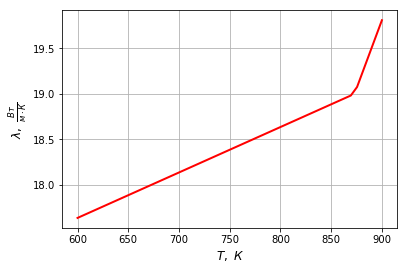

In [5]:
lam_blade_arr = np.array([17, 19, 22, 24, 27, 29])
T_wall_arr = np.array([200, 600, 700, 800, 900, 1200]) + 273
lam_blade_int = interp1d(T_wall_arr, lam_blade_arr, bounds_error=False, fill_value='extrapolate')

T_material_max = 1173
T_arr = np.linspace(600, 900, 50)
plt.plot(T_arr, lam_blade_int(T_arr), lw=2, color='red')
plt.grid()
plt.xlabel(r'$T,\ К$', fontsize=12)
plt.ylabel(r'$\lambda,\ \frac{Вт}{м \cdot К}$', fontsize=12)
plt.show()

### Параметры теплозащитного покрытия

Покрытие: $ Zr O_2 - Y_2 O_3 $.

In [6]:
lam_cover = 2.3
cover_thickness = 0.2e-3

Теплопроводность: {{ lam_cover }} $\ Вт/(м \cdot К)$.

Толщина: {{ cover_thickness * 1e6 }} $мкм $.

## Задание входных параметров

### Неравномерность температуры газа на входе

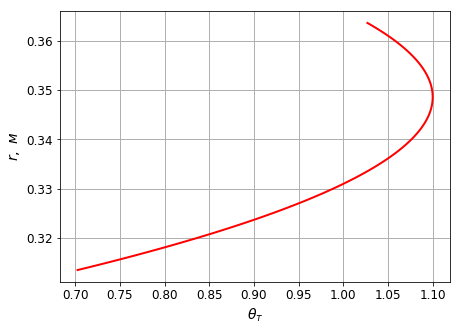

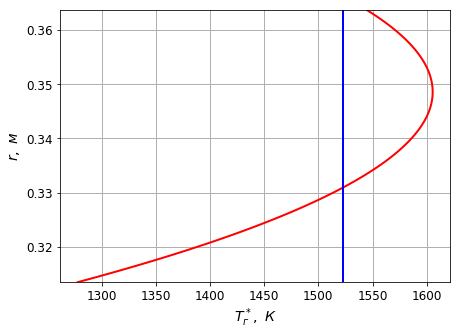

In [7]:
# максимальная неравномерность
theta_t_max = 1.1
# относительное положение макимума
r_max_rel = 0.7
# внутренний радиус 
r_in = 0.5 * profiling.D_in
# наружний радиус
r_out = 0.5 * profiling.D_out
# среднемассовая температура газа на входе
T_gas_stag_av = turbine[0].T0_stag

# функция неравномерности температуры
theta_t = get_theta(r_in=r_in, r_out=r_out, r_max_rel=r_max_rel, theta_max=theta_t_max)

r_arr = np.linspace(r_in, r_out, 100)

plt.figure(figsize=(7, 5))
plt.plot([theta_t(r) for r in r_arr], r_arr, lw=2, color='red')
plt.grid(linewidth=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(os.path.join(config.draw_plots_dir, 'cool_theta_T.png'))
plt.ylabel(r'$r,\ м$', fontsize=14)
plt.xlabel(r'$\theta_{т}$', fontsize=14)
plt.savefig('plots/sa1_cool_theta_T.png')
plt.show()

# распределение температуры на входе
T_gas_stag_in = get_T_gas(theta_gas=theta_t, T_c_stag=T_c_stag, T_gas_stag_av=T_gas_stag_av)

plt.figure(figsize=(7, 5))
plt.plot([T_gas_stag_in(r) for r in r_arr], r_arr, lw=2, color='red')
plt.plot([T_gas_stag_av, T_gas_stag_av], [min(r_arr), max(r_arr)], lw=2, color='blue')
plt.ylim(min(r_arr), max(r_arr))
plt.grid(linewidth=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel(r'$r,\ м$', fontsize=14)
plt.xlabel(r'$T_г^*,\ К$', fontsize=14)
plt.show()

### Неравномерность плотности расхода охлаждающего воздуха по высоте

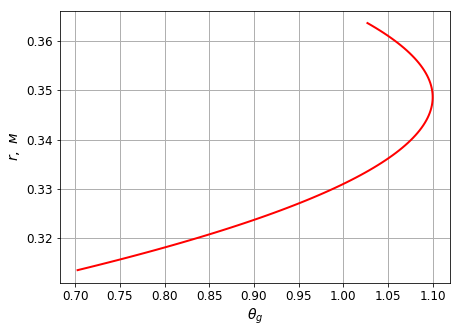

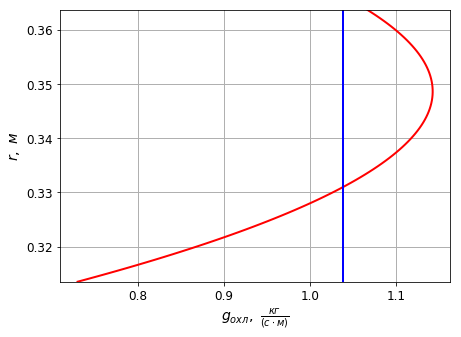

In [9]:
# максимальная неравномерность
theta_g_max = 1.1
# относительный расход охлаждающего воздуха на СА
g_cool_sa = 0.055
G_cool0 = G_air * g_cool_sa / blade_num
# средняя плотность расхода охлаждающего воздуха
g_cool0_av = G_cool0 / (r_out - r_in)

# функция неравномерности плотности расхода
theta_g = get_theta(r_in=r_in, r_out=r_out, r_max_rel=r_max_rel, theta_max=theta_g_max)

plt.figure(figsize=(7, 5))
plt.plot([theta_g(r) for r in r_arr], r_arr, lw=2, color='red')
plt.grid(linewidth=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(os.path.join(config.draw_plots_dir, 'cool_theta_g.png'))
plt.ylabel(r'$r,\ м$', fontsize=14)
plt.xlabel(r'$\theta_{g}$', fontsize=14)
plt.savefig('plots/sa1_cool_theta_g.png')
plt.show()

# распределение плотности расхода охлаждающего воздуха по высоте
g_cool0 = get_g_cool(theta_g=theta_g, g_cool_av=g_cool0_av)

plt.figure(figsize=(7, 5))
plt.plot([g_cool0(r) for r in r_arr], r_arr, lw=2, color='red')
plt.plot([g_cool0_av, g_cool0_av], [min(r_arr), max(r_arr)], lw=2, color='blue')
plt.ylim(min(r_arr), max(r_arr))
plt.grid(linewidth=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel(r'$r,\ м$', fontsize=14)
plt.xlabel(r'$g_{охл},\  \frac{кг}{(c \cdot м)}$', fontsize=14)
plt.show()

1. Относительный расход на охлаждение СА - {{ str(round(g_cool_sa, 3)) }}
2. Абсолютный расход на охлаждение СА - {{ str(round(g_cool_sa * G_air, 2)) }} кг/с.
3. Абсолютный расход на охлаждение одной допатки СА - {{ str((round(G_cool0, 3))) }}

In [10]:
# координаты отверстий
x_hole_rel = [-0.86, -0.69, -0.12, 0.1, 0.35, 0.55, 0.8]
# Диаметры отверстий
d_hole = [0.35e-3, 0.3e-3, 0.3e-3, 0.3e-3, 0.3e-3, 0.3e-3, 0.3e-3]
# Количества отверстий
hole_num = [35, 40, 40, 40, 40, 46, 50]
# коэффициент скорости
phi = 0.9
# коэффициент расхода
mu = 0.85
# давление воздуха на входе в лопатку
p_cool_stag0 = p_c_stag * 0.99
# Температура воздуха на входе в лопатку
T_cool0 = T_c_stag + 50
# ширина канала между стенкой и дефлектором
channel_width = 0.0007 
# толщина стенки
wall_thickness=0.001
T_wall_out_av_init=1023

sa1_film_cooler = get_sa_cooler(profiling=profiling, 
                                channel_width=channel_width, 
                                wall_thickness=wall_thickness, 
                                T_wall_out_av_init=T_wall_out_av_init, 
                                lam_blade=lambda T: lam_blade_int(T).__float__(),
                                x_hole_rel=x_hole_rel, 
                                hole_num=hole_num, 
                                d_hole=d_hole, 
                                phi_hole=[phi for _ in x_hole_rel], 
                                mu_hole=[mu for _ in x_hole_rel],
                                work_fluid=type(turbine.work_fluid)(),
                                T_cool0=T_cool0,
                                p_cool_stag0=p_cool_stag0,
                                cool_fluid=Air(),
                                g_cool0=g_cool0,
                                cover_thickness=cover_thickness,
                                lam_cover=lam_cover,
                                node_num=250,
                                accuracy=0.01, 
                                g_cool0_s=0.5)

sa1_film_cooler.T_gas_stag = T_gas_stag_in
sa1_film_cooler.make_partition()
init_params = pd.DataFrame.from_dict({'Name': [
    'Ширина канал, мм',
    'Толщина стенки, мм',
    'Координаты рядов отверстий',
    'Кол-ва отверстий в рядах',
    'Диаметры отверстий, мм',
    'К-ты скорости',
    'К-ты расхода',
    'Расход газа, кг/с',
    'Т-ра воздуха на входе, К',
    'Давление воздуха на входе, МПа',
    'Расход воздуха на лопатку, кг/с',
    'Относительный расход вохдуха на СА'
], 
                                      'Value': [
                                          sa1_film_cooler.channel_width * 1e3,
                                          sa1_film_cooler.wall_thickness * 1e3,
                                          sa1_film_cooler.x_hole_rel,
                                          sa1_film_cooler.hole_num,
                                          np.array(sa1_film_cooler.d_hole) * 1e3,
                                          sa1_film_cooler.phi_hole,
                                          sa1_film_cooler.mu_hole,
                                          sa1_film_cooler.G_gas,
                                          sa1_film_cooler.T_cool0,
                                          sa1_film_cooler.p_cool_stag0 / 1e6,
                                          round(sa1_film_cooler.G_cool0, 3),
                                          round(sa1_film_cooler.G_cool0 * blade_num / G_air, 3)
                                      ]})
init_params

,Name,Value
0,"Ширина канал, мм",0.7
1,"Толщина стенки, мм",1
2,Координаты рядов отверстий,"[-0.86, -0.69, -0.12, 0.1, 0.35, 0.55, 0.8]"
3,Кол-ва отверстий в рядах,"[35, 40, 40, 40, 40, 46, 50]"
4,"Диаметры отверстий, мм","[0.35, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]"
5,К-ты скорости,"[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]"
6,К-ты расхода,"[0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85]"
7,"Расход газа, кг/с",38.5762
8,"Т-ра воздуха на входе, К",747.965
9,"Давление воздуха на входе, МПа",1.68825


## Разбиение на сектора по высоте лопатки

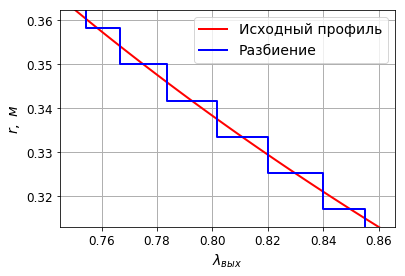

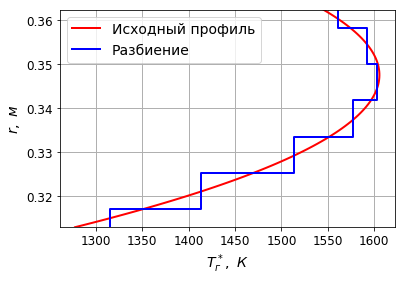

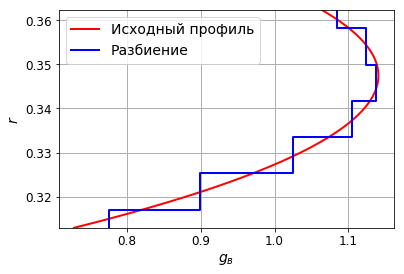

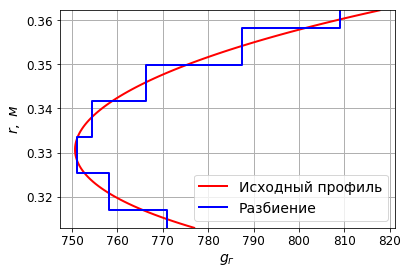

In [190]:
sa1_film_cooler.plot_lam_gas_out(filename=os.path.join(config.plots_dir, 'cool_lam_out_part.png'))
sa1_film_cooler.plot_T_gas_stag(filename=os.path.join(config.plots_dir, 'cool_T_gas_stag_part.png'))
sa1_film_cooler.plot_g_cool(filename=os.path.join(config.plots_dir, 'cool_g_cool0_part.png'))
sa1_film_cooler.plot_g_gas(filename=os.path.join(config.plots_dir, 'cool_g_gas_part.png'))

## Сохранение геометричеих параметров в файл

In [191]:
sa1_film_cooler.write_nx_exp_file(os.path.join(config.output_dirname, 'cool_av_sec_holes.exp'), sector_num=3)
sa1_film_cooler.write_excel_table(os.path.join(config.output_dirname, 'cool_av_sec_holes.xls'), sector_num=3)

In [192]:
sa1_film_cooler.compute()

INFO - Computing sector №0
INFO - Sector computing: Iter №1, residual = 1.0000
INFO - Sector computing: Iter №2, residual = 1403.0576
INFO - Sector computing: Iter №3, residual = 26.9665
INFO - Sector computing: Iter №4, residual = 0.3635
INFO - Sector computing: Iter №5, residual = 0.0042
INFO - Computing sector №1
INFO - Sector computing: Iter №1, residual = 1.0000
INFO - Sector computing: Iter №2, residual = 1483.5918
INFO - Sector computing: Iter №3, residual = 29.2273
INFO - Sector computing: Iter №4, residual = 0.3249
INFO - Sector computing: Iter №5, residual = 0.0032
INFO - Computing sector №2
INFO - Sector computing: Iter №1, residual = 1.0000
INFO - Sector computing: Iter №2, residual = 1545.4404
INFO - Sector computing: Iter №3, residual = 31.6326
INFO - Sector computing: Iter №4, residual = 0.2909
INFO - Sector computing: Iter №5, residual = 0.0025
INFO - Computing sector №3
INFO - Sector computing: Iter №1, residual = 1.0000
INFO - Sector computing: Iter №2, residual = 157

## Результаты расчета для всех секторов

### Температура стенки

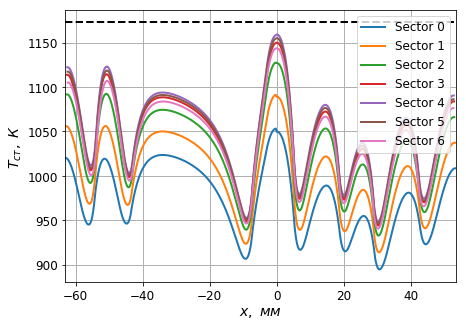

In [193]:
sa1_film_cooler.plot_T_wall(T_material=T_material_max, filename=os.path.join(config.plots_dir, 'cool_T_wall_all_sectors.png'))

### Температура охлаждающего воздуха

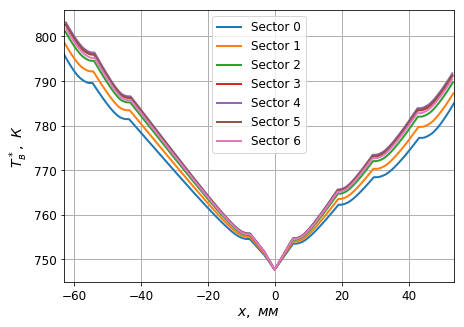

In [194]:
sa1_film_cooler.plot_T_cool(filename=os.path.join(config.plots_dir, 'cool_T_cool_all_sectors.png'))

### Температура пленки

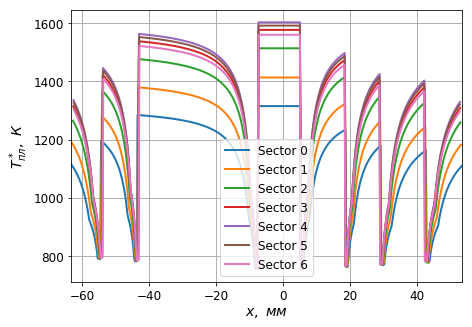

In [195]:
sa1_film_cooler.plot_T_film(filename=os.path.join(config.plots_dir, 'cool_T_film_all_sectors.png'))

### Изменение температуры наиболее горячего участка стенки по высоте 

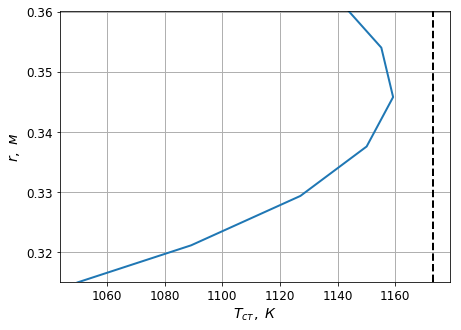

In [196]:
hot_sector_num = 4
hot_sector: FilmSectorCooler = sa1_film_cooler.sectors[hot_sector_num]
hot_loc_params: LocalParamCalculator = hot_sector.local_param
hot_film: FilmCalculator = hot_sector.film
x_T_max = hot_loc_params.x_arr[hot_loc_params.T_wall_arr.tolist().index(max(hot_loc_params.T_wall_arr))]
sa1_film_cooler.plot_T_wall_in_point(x_T_max*0.996, T_material_max=T_material_max, 
                                     filename=os.path.join(config.plots_dir, 'cool_T_wall_hot_point.png'))

### Сохранение результатов в файл

In [197]:
sa1_film_cooler.save_results(os.path.join(config.output_dirname, 'cool_results'))

## Результаты для наиболее нагруженного сектора

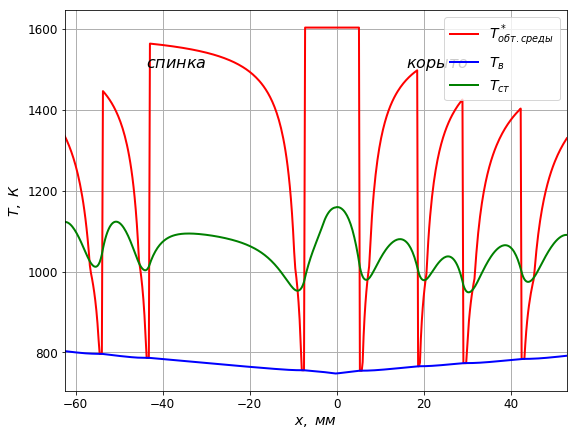

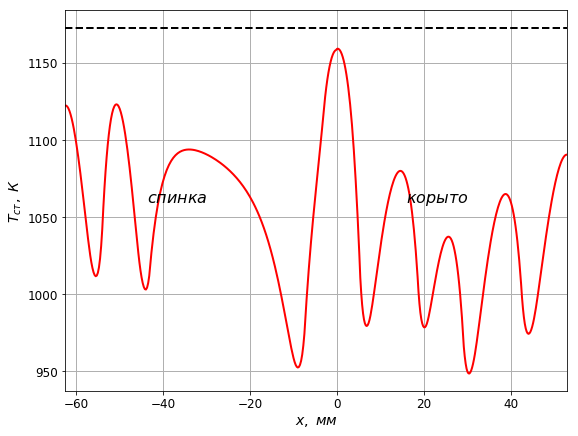

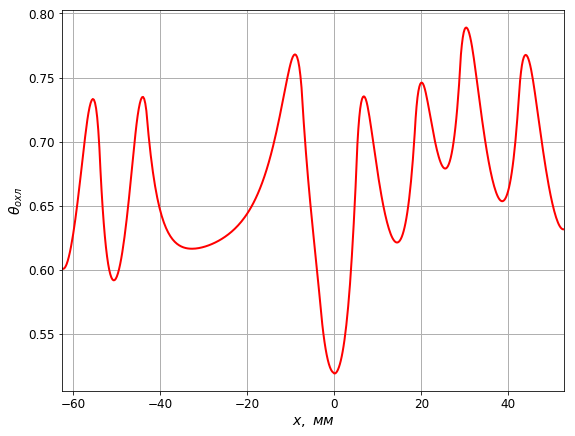

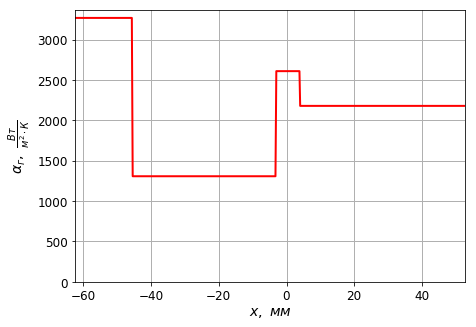

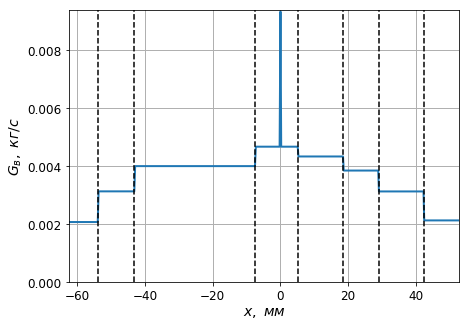

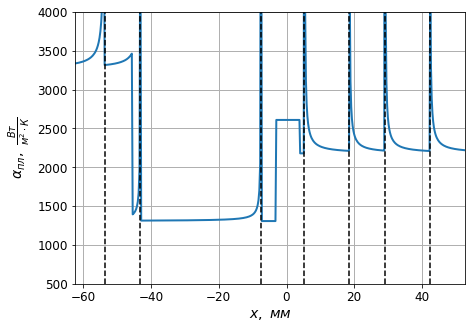

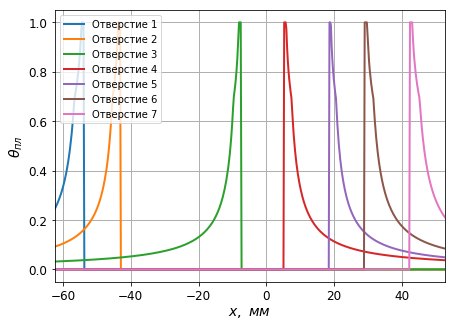

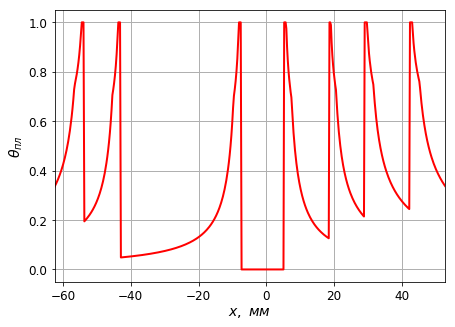

In [198]:
hot_loc_params.plot_all(figsize=(9, 7), 
                        filename=os.path.join(config.plots_dir, 'cool_T_all_hot_sector.png'))
hot_loc_params.plot_T_wall(figsize=(9, 7), T_material_max=T_material_max, 
                           filename=os.path.join(config.plots_dir, 'cool_T_wall_hot_sector.png'))
hot_sector.plot_cool_eff(figsize=(9, 7), 
                         filename=os.path.join(config.plots_dir, 'cool_cool_eff_hot_sector.png'))
hot_sector.plot_alpha_gas(figsize=(7, 5), 
                          filename=os.path.join(config.plots_dir, 'cool_alpha_gas.png'))
hot_film.plot_G_cool(hot_loc_params.x_arr, figsize=(7, 5), 
                     filename=os.path.join(config.plots_dir, 'cool_G_cool_hot_sector.png'))
hot_film.plot_alpha_film(hot_loc_params.x_arr, (500, 4000), figsize=(7, 5), 
                         filename=os.path.join(config.plots_dir, 'cool_alpha_film.png'))
hot_film.plot_film_eff(0, hot_loc_params.x_arr, True, False, (7, 5))
hot_film.plot_film_eff(1, hot_loc_params.x_arr, False, False)
hot_film.plot_film_eff(2, hot_loc_params.x_arr, False, False)
hot_film.plot_film_eff(3, hot_loc_params.x_arr, False, False)
hot_film.plot_film_eff(4, hot_loc_params.x_arr, False, False)
hot_film.plot_film_eff(5, hot_loc_params.x_arr, False, False)
hot_film.plot_film_eff(6, hot_loc_params.x_arr, False, True, 
                       filename=os.path.join(config.plots_dir, 'cool_film_eff_hot_sector.png'))
hot_film.plot_integrate_film_eff(hot_loc_params.x_arr, figsize=(7, 5), 
                                 filename=os.path.join(config.plots_dir, 'cool_integrate_film_eff_hot_sector.png'))

## Интегральная эффективность охлаждения

In [199]:
theta = (turbine[0].T0_stag - sa1_film_cooler.T_wall_out_av) / (turbine[0].T0_stag - sa1_film_cooler.T_cool_av)

Эффективность охлаждения $\theta = $ {{ str(round(theta, 3)) }}

## Результаты для слабонагруженного сектора

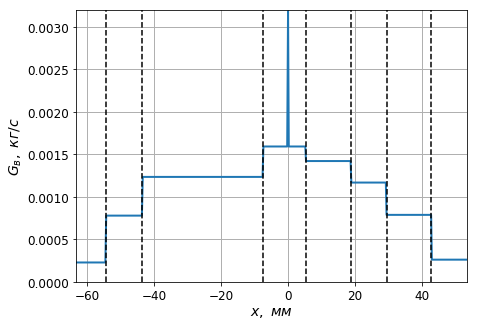

In [200]:
cold_sector: FilmSectorCooler = sa1_film_cooler.sectors[0]
cold_loc_params: LocalParamCalculator = cold_sector.local_param
cold_film: FilmCalculator = cold_sector.film
cold_film.plot_G_cool(cold_loc_params.x_arr, figsize=(7, 5))

## Расчет для лопатки без покрытия

In [201]:
sa1_film_cooler_naked = get_sa_cooler(profiling=profiling, 
                                channel_width=channel_width, 
                                wall_thickness=wall_thickness, 
                                T_wall_out_av_init=T_wall_out_av_init, 
                                lam_blade=lambda T: lam_blade_int(T).__float__(),
                                x_hole_rel=x_hole_rel, 
                                hole_num=hole_num, 
                                d_hole=d_hole, 
                                phi_hole=[phi for _ in x_hole_rel], 
                                mu_hole=[mu for _ in x_hole_rel],
                                work_fluid=type(turbine.work_fluid)(),
                                T_cool0=T_cool0,
                                p_cool_stag0=p_cool_stag0,
                                cool_fluid=Air(),
                                g_cool0=g_cool0,
                                cover_thickness=0,
                                lam_cover=lam_cover,
                                node_num=250,
                                accuracy=0.01, 
                                g_cool0_s=0.5)

sa1_film_cooler_naked.T_gas_stag = T_gas_stag_in
sa1_film_cooler_naked.make_partition()

In [202]:
sa1_film_cooler_naked.compute()

INFO - Computing sector №0
INFO - Sector computing: Iter №1, residual = 1.0000
INFO - Sector computing: Iter №2, residual = 1747.2226
INFO - Sector computing: Iter №3, residual = 29.3477
INFO - Sector computing: Iter №4, residual = 0.4196
INFO - Sector computing: Iter №5, residual = 0.0052
INFO - Computing sector №1
INFO - Sector computing: Iter №1, residual = 1.0000
INFO - Sector computing: Iter №2, residual = 1847.4290
INFO - Sector computing: Iter №3, residual = 32.7897
INFO - Sector computing: Iter №4, residual = 0.3892
INFO - Sector computing: Iter №5, residual = 0.0042
INFO - Computing sector №2
INFO - Sector computing: Iter №1, residual = 1.0000
INFO - Sector computing: Iter №2, residual = 1922.0930
INFO - Sector computing: Iter №3, residual = 36.2393
INFO - Sector computing: Iter №4, residual = 0.3589
INFO - Sector computing: Iter №5, residual = 0.0033
INFO - Computing sector №3
INFO - Sector computing: Iter №1, residual = 1.0000
INFO - Sector computing: Iter №2, residual = 195

In [204]:
hot_sector_naked: FilmSectorCooler = sa1_film_cooler_naked.sectors[hot_sector_num]
hot_loc_params_naked: LocalParamCalculator = hot_sector_naked.local_param
hot_film_naked: FilmCalculator = hot_sector_naked.film
x_T_max = hot_loc_params_naked.x_arr[hot_loc_params_naked.T_wall_arr.tolist().index(max(hot_loc_params_naked.T_wall_arr))]

### Влияние покрытия на температуру стенки на наиболее нагруженном секторе

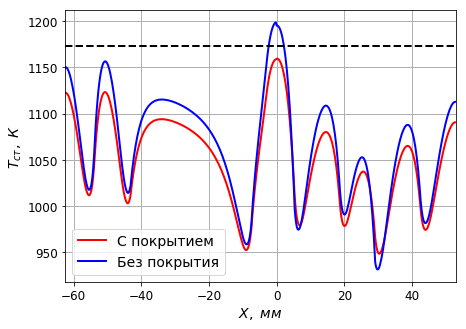

In [205]:
T_wall_cover = hot_loc_params.T_wall_arr
T_wall_naked = hot_loc_params_naked.T_wall_arr
x_arr = hot_loc_params.x_arr * 1e3

plt.figure(figsize=(7, 5))
plt.plot(x_arr, T_wall_cover, lw=2, color='red', label='C покрытием')
plt.plot(x_arr, T_wall_naked, lw=2, color='blue', label='Без покрытия')
plt.plot([min(x_arr), max(x_arr)], [T_material_max, T_material_max], lw=2, linestyle='--', color='black')
plt.legend(fontsize=14)
plt.grid(linewidth=1)
plt.xlim(min(x_arr), max(x_arr))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(os.path.join(config.draw_plots_dir, 'cool_T_wall_cover_influence.png'))
plt.xlabel(r'$X,\ мм$', fontsize=14)
plt.ylabel(r'$T_{ст},\ К$', fontsize=14)
plt.savefig(os.path.join(config.plots_dir, 'cool_T_wall_cover_influence.png'))
plt.show()

## Графики для черетежей

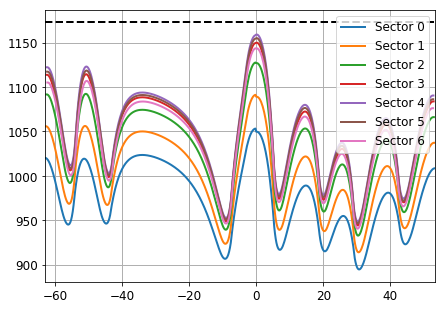

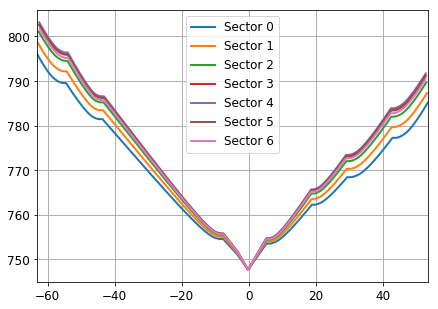

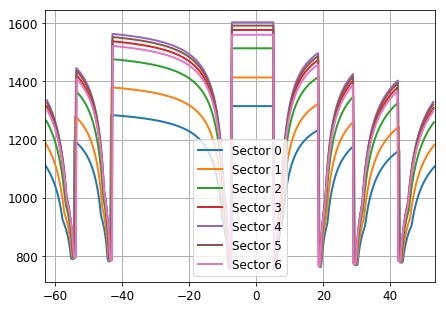

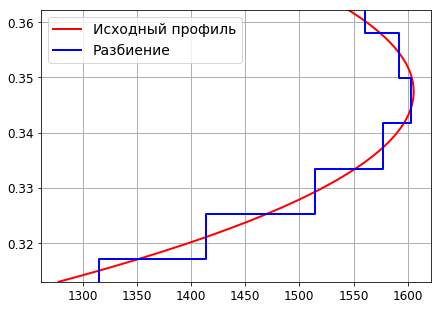

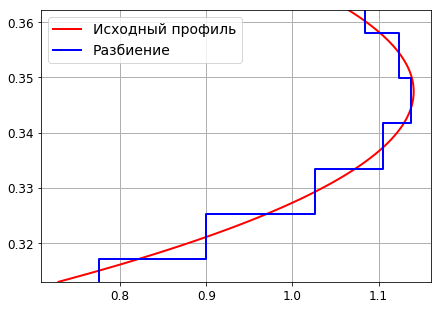

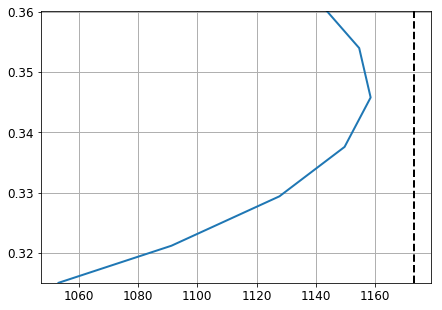

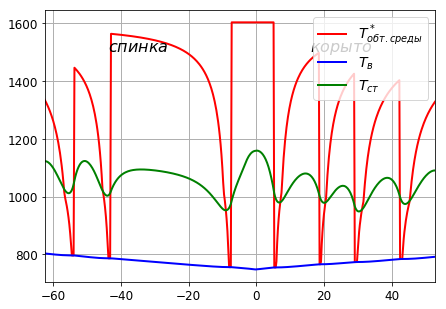

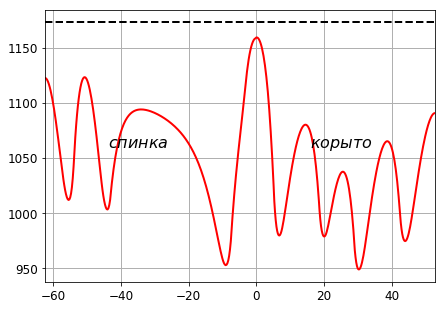

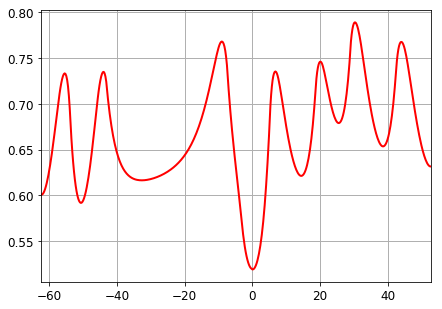

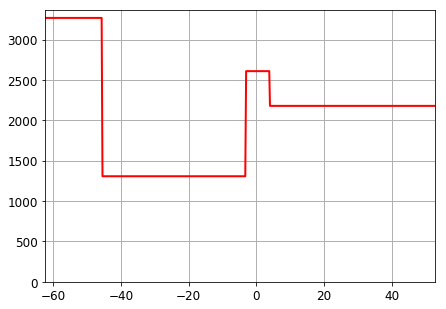

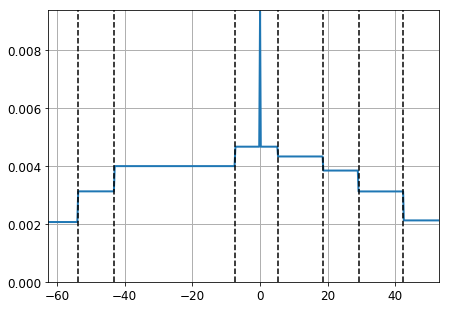

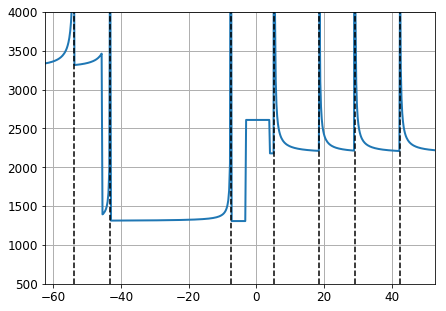

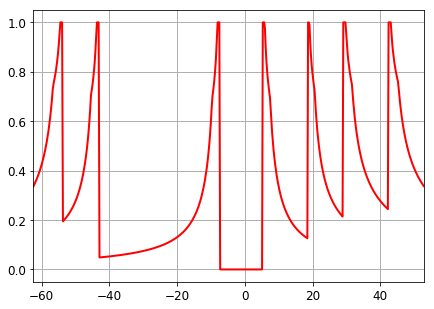

In [207]:
sa1_film_cooler.plot_T_wall(T_material=T_material_max, 
                            filename=os.path.join(config.draw_plots_dir, 'cool_T_wall_all_sectors.png'), 
                            label=False, figsize=(7, 5))
sa1_film_cooler.plot_T_cool(filename=os.path.join(config.draw_plots_dir, 'cool_T_cool_all_sectors.png'), 
                            label=False, figsize=(7, 5))
sa1_film_cooler.plot_T_film(filename=os.path.join(config.draw_plots_dir, 'cool_T_film_all_sectors.png'), 
                            label=False, figsize=(7, 5))
sa1_film_cooler.plot_T_gas_stag(filename=os.path.join(config.draw_plots_dir, 'cool_T_gas_stag_part.png'), 
                                label=False, figsize=(7, 5))
sa1_film_cooler.plot_g_cool(filename=os.path.join(config.draw_plots_dir, 'cool_g_cool0_part.png'), 
                            label=False, figsize=(7, 5))
sa1_film_cooler.plot_T_wall_in_point(x_T_max*0.996, T_material_max=T_material_max, 
                                     filename=os.path.join(config.draw_plots_dir, 'cool_T_wall_hot_point.png'), 
                                     label=False, figsize=(7, 5))

hot_loc_params.plot_all(figsize=(7, 5), label=False, 
                        filename=os.path.join(config.draw_plots_dir, 'cool_T_all_hot_sector.png'))
hot_loc_params.plot_T_wall(figsize=(7, 5), T_material_max=T_material_max, label=False,
                           filename=os.path.join(config.draw_plots_dir, 'cool_T_wall_hot_sector.png'))

hot_sector.plot_cool_eff(figsize=(7, 5), label=False, 
                         filename=os.path.join(config.draw_plots_dir, 'cool_cool_eff_hot_sector.png'))
hot_sector.plot_alpha_gas(figsize=(7, 5), label=False, 
                          filename=os.path.join(config.draw_plots_dir, 'cool_alpha_gas.png'))

hot_film.plot_G_cool(hot_loc_params.x_arr, figsize=(7, 5), label=False,
                     filename=os.path.join(config.draw_plots_dir, 'cool_G_cool_hot_sector.png'))
hot_film.plot_alpha_film(hot_loc_params.x_arr, (500, 4000), figsize=(7, 5), label=False,
                         filename=os.path.join(config.draw_plots_dir, 'cool_alpha_film.png'))

hot_film.plot_integrate_film_eff(hot_loc_params.x_arr, figsize=(7, 5), label=False,
                                 filename=os.path.join(config.draw_plots_dir, 'cool_integrate_film_eff_hot_sector.png'))